In [ ]:
import os
import mlflow
import numpy as np
import pandas as pd

from math import sqrt
from joblib import delayed
from joblib import Parallel

from warnings import catch_warnings
from warnings import filterwarnings
from multiprocessing import cpu_count
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib import pyplot
import matplotlib.dates as mdates

from pathlib import Path
from functools import reduce
from datetime import datetime

import random
from scipy.stats import ttest_ind
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression, RidgeCV, Ridge, LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from regressors import stats
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

## Load data 

In [4]:
df = pd.read_csv('./VAR_preds_for_crisis_months.csv', converters={'ags2': str, 'ags5': str} )
#df.set_index('ags5', drop=True, inplace=True)
df['date'] = pd.to_datetime(df['date'], format = '%Y-%m-%d')
# fix ags5 missing 0 
df['ags5'] = np.where(df.ags5.str.len() ==4, '0' + df['ags5'], df['ags5'])

In [6]:
df2 = pd.read_csv('./../data/corona_data_sets/pendler.csv', converters={'ags2': str, 'ags5': str} )
df2 = df2[['ags2', 'bundesland', 'kreis','ags5']]
# fix ags5 missing 0 
df2['ags5'] = np.where(df2.ags5.str.len() ==4, '0' + df2['ags5'], df2['ags5'])
df = pd.merge(df, df2, left_on = 'ags5', right_on = 'ags5')
df

,date,ground_truth,pred,ags5,ags2,bundesland,kreis
0,2020-01-01,8.4,8.36,01001,1,Schleswig-Holstein,"Flensburg, Stadt"
1,2020-02-01,8.4,8.30,01001,1,Schleswig-Holstein,"Flensburg, Stadt"
2,2020-03-01,8.2,8.21,01001,1,Schleswig-Holstein,"Flensburg, Stadt"
3,2020-04-01,9.3,8.07,01001,1,Schleswig-Holstein,"Flensburg, Stadt"
4,2020-05-01,9.9,7.84,01001,1,Schleswig-Holstein,"Flensburg, Stadt"
...,...,...,...,...,...,...,...
6812,2021-01-01,7.3,6.42,16077,16,Thüringen,Altenburger Land
6813,2021-02-01,7.3,6.38,16077,16,Thüringen,Altenburger Land
6814,2021-03-01,7.2,6.09,16077,16,Thüringen,Altenburger Land
6815,2021-04-01,6.9,5.70,16077,16,Thüringen,Altenburger Land


In [8]:
df.to_csv('./../data/counterfactual.csv')

## Plot ground truth vs pred

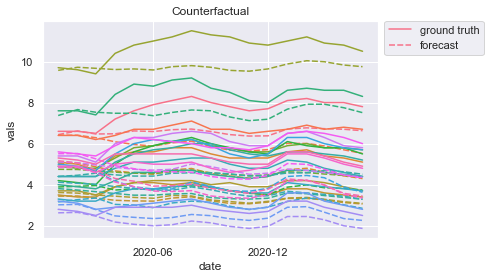

In [213]:
df_long = df.melt(id_vars=['date','ags2', 'bundesland', 'kreis','ags5'], var_name='y_type', value_name='vals')
sample_args = random.sample(list(set(df_long['ags5'])), 20)
df_sample = df_long[df_long['ags5'].isin(sample_args)]
g = sns.lineplot(data=df_sample, x="date", y="vals",  hue="ags5", style="y_type")
g.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
g.legend_.remove()
g.set_title('Counterfactual')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, labels=['ground truth', 'forecast'])
plt.savefig('counter_sample.png')

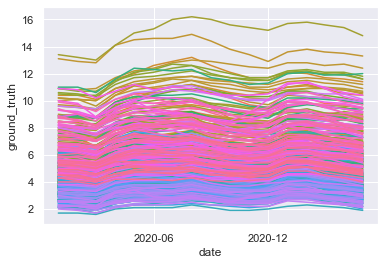

In [118]:
g = sns.lineplot(data=df, x="date", y="ground_truth",  hue="ags5")
g.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
g.legend_.remove()

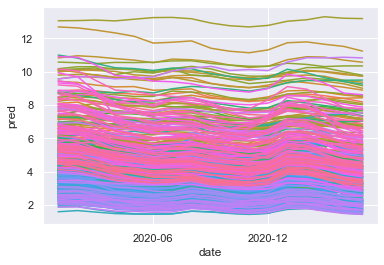

In [119]:
g = sns.lineplot(data=df, x="date", y="pred",  hue="ags5")
g.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
g.legend_.remove()

## Look into errors

In [228]:
df['error'] = (df['ground_truth']-df['pred'])/df['pred']

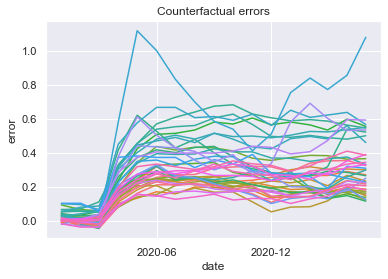

In [232]:
sample_args = random.sample(list(set(df['ags5'])), 40)
df_sample = df[df['ags5'].isin(sample_args)]

g = sns.lineplot(data=df_sample, x="date", y="error",  hue="ags5")
g.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
g.set_title('Counterfactual errors')
g.legend_.remove()

In [122]:
df.sort_values(by=['error'], ascending=False)

,date,ground_truth,pred,ags5,ags2,bundesland,kreis,error
3982,2020-05-01,4.7,2.22,09180,9,Freistaat Bayern,Garmisch-Partenkirchen,1.117117
3994,2021-05-01,3.7,1.78,09180,9,Freistaat Bayern,Garmisch-Partenkirchen,1.078652
3983,2020-06-01,4.1,2.05,09180,9,Freistaat Bayern,Garmisch-Partenkirchen,1.000000
3858,2021-05-01,4.3,2.29,09172,9,Freistaat Bayern,Berchtesgadener Land,0.877729
5915,2021-05-01,10.0,5.38,13073,13,Mecklenburg-Vorpommern,Vorpommern-Rügen,0.858736
...,...,...,...,...,...,...,...,...
1903,2021-05-01,7.0,7.65,05962,5,Nordrhein-Westfalen,Märkischer Kreis,-0.084967
5422,2021-05-01,9.9,10.83,10041,10,Saarland,Regionalverband Saarbrücken,-0.085873
6717,2020-03-01,4.0,4.38,16072,16,Thüringen,Sonneberg,-0.086758
2076,2020-03-01,4.8,5.27,06433,6,Hessen,Groß-Gerau,-0.089184


## Look into mean errors


In [124]:
df_mean_error = df.groupby(['ags2', 'bundesland', 'kreis','ags5']).mean()
df_mean_error   

ground_truth  \
ags2 bundesland         kreis                      ags5                  
1    Schleswig-Holstein Dithmarschen               01051      6.235294   
                        Flensburg, Stadt           01001      9.094118   
                        Herzogtum Lauenburg        01053      5.523529   
                        Kiel, Landeshauptstadt     01002      8.517647   
                        Lübeck, Hansestadt         01003      8.323529   
...                                                                ...   
9    Freistaat Bayern   Weilheim-Schongau          09190      2.941176   
                        Weißenburg-Gunzenhausen    09577      3.570588   
                        Wunsiedel i.Fichtelgebirge 09479      5.164706   
                        Würzburg                   09663      4.152941   
                                                   09679      2.382353   

                                                              pred     error  
ags2 bundesland         kreis                      ags5                       
1    Schleswig-Holstein Dithmarschen               01051  5.051765  0.245177  
                        Flensburg, Stadt           01001  7.798235  0.168296  
                        Herzogtum Lauenburg        01053  4.554118  0.217150  
                        Kiel, Landeshauptstadt     01002  7.147059  0.193707  
                        Lübeck, Hansestadt         01003  6.834118  0.221480  
...                                                            ...       ...  
9    Freistaat Bayern   Weilheim-Schongau          09190  2.062353  0.446504  
                        Weißenburg-Gunzenhausen    09577  2.922353  0.231754  
                        Wunsiedel i.Fichtelgebirge 09479  4.655294  0.113693  
                        Würzburg                   09663  3.178235  0.311083  
                                                   09679  1.825294  0.311784  

[401 rows x 3 columns]

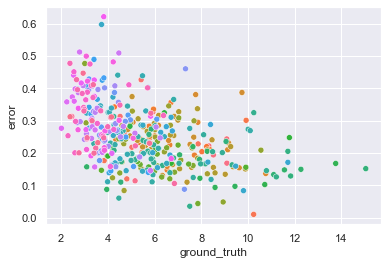

In [125]:
g = sns.scatterplot(data=df_mean_error, x="ground_truth", y="error",  hue="ags5")
g.legend_.remove()

In [126]:
df_mean_error.sort_values(by=['error'], ascending=False)

ground_truth  \
ags2 bundesland          kreis                       ags5                  
9    Freistaat Bayern    Garmisch-Partenkirchen      09180      3.823529   
7    Rheinland-Pfalz     Rhein-Lahn-Kreis            07141      3.729412   
9    Freistaat Bayern    Dachau                      09174      2.788235   
                         Berchtesgadener Land        09172      4.470588   
                         Landsberg am Lech           09181      3.076471   
...                                                                  ...   
5    Nordrhein-Westfalen Steinfurt                   05566      4.470588   
3    Niedersachsen       Emden                       03402      8.935294   
                         Lüchow-Dannenberg           03354      7.852941   
5    Nordrhein-Westfalen Märkischer Kreis            05962      7.505882   
10   Saarland            Regionalverband Saarbrücken 10041     10.241176   

                                                                 pred  \
ags2 bundesland          kreis                       ags5               
9    Freistaat Bayern    Garmisch-Partenkirchen      09180   2.422941   
7    Rheinland-Pfalz     Rhein-Lahn-Kreis            07141   2.372353   
9    Freistaat Bayern    Dachau                      09174   1.855882   
                         Berchtesgadener Land        09172   3.042941   
                         Landsberg am Lech           09181   2.077059   
...                                                               ...   
5    Nordrhein-Westfalen Steinfurt                   05566   4.220000   
3    Niedersachsen       Emden                       03402   8.528824   
                         Lüchow-Dannenberg           03354   7.536471   
5    Nordrhein-Westfalen Märkischer Kreis            05962   7.264118   
10   Saarland            Regionalverband Saarbrücken 10041  10.157647   

                                                               error  
ags2 bundesland          kreis                       ags5             
9    Freistaat Bayern    Garmisch-Partenkirchen      09180  0.621183  
7    Rheinland-Pfalz     Rhein-Lahn-Kreis            07141  0.597062  
9    Freistaat Bayern    Dachau                      09174  0.511960  
                         Berchtesgadener Land        09172  0.508944  
                         Landsberg am Lech           09181  0.499209  
...                                                              ...  
5    Nordrhein-Westfalen Steinfurt                   05566  0.060244  
3    Niedersachsen       Emden                       03402  0.048266  
                         Lüchow-Dannenberg           03354  0.043417  
5    Nordrhein-Westfalen Märkischer Kreis            05962  0.035144  
10   Saarland            Regionalverband Saarbrücken 10041  0.009949  

[401 rows x 3 columns]

# Load structural data

In [142]:
df_structural = pd.read_csv('./../../final_dfs/for_modeling/df_final_stationery.csv', converters={'ags2': str, 'ags5': str} )
# fix ags5 missing 0 
df_structural['ags5'] = np.where(df_structural.ags5.str.len() ==4, '0' + df_structural['ags5'],df_structural['ags5']) 
df_structural["urban_/_rural"] = np.where(df_structural["urban_/_rural"]==1, 'urban', 'rural')
df_structural['eligible_area'] = np.where(df_structural['eligible_area']==1, 'eligible_area', 'not_eligible_area')
df_structural['east_west'] = np.where(df_structural['east_west']==1, 'west', 'east')
df_structural = df_structural.rename(columns={'urban_/_rural': 'urban_rural'})
df_structural

,cluster,kreis,ags5,ags2,supermarkets_population,supermarkets_average_distance,public_transport_availability,average_distance_bus_stop,average_distance_train_station,average_distance_public_transport,...,room_type_location,district_settlement_structure,type_of_settlement_structure,urban_rural,metropolitan_region,metropolitan_area,east_west,border_proximity,support_area_status,eligible_area
0,0,"Flensburg, Stadt",01001,01,92,500,35,240,2901,240,...,2,4,3,rural,99,99,west,1,C,eligible_area
1,2,"Kiel, Landeshauptstadt",01002,01,92,460,37,268,2037,265,...,2,1,2,urban,99,99,west,0,C/D,eligible_area
2,2,"Lübeck, Hansestadt",01003,01,90,532,37,297,1927,294,...,1,1,2,urban,5,99,west,0,C/D,eligible_area
3,0,"Neumünster, Stadt",01004,01,85,588,37,316,1648,313,...,2,3,2,rural,5,99,west,0,D,eligible_area
4,0,Dithmarschen,01051,01,51,1864,35,448,3517,443,...,4,4,3,rural,5,99,west,0,C,eligible_area
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,0,Saalfeld-Rudolstadt,16073,16,62,1423,37,341,2492,322,...,3,4,2,rural,99,99,east,0,C*,eligible_area
397,0,Saale-Holzland-Kreis,16074,16,54,1677,38,343,3419,340,...,3,3,2,rural,99,99,east,0,C*,eligible_area
398,0,Saale-Orla-Kreis,16075,16,54,1686,35,449,3172,444,...,3,4,2,rural,99,99,east,2,C*,eligible_area
399,0,Greiz,16076,16,55,1654,38,608,2779,563,...,3,2,2,urban,99,99,east,0,C*,eligible_area


In [143]:
df_mixed = pd.merge(df_mean_error, df_structural, on = ['ags2', 'kreis','ags5'])
list(df_mixed.columns)

['ags2',
 'kreis',
 'ags5',
 'ground_truth',
 'pred',
 'error',
 'cluster',
 'supermarkets_population',
 'supermarkets_average_distance',
 'public_transport_availability',
 'average_distance_bus_stop',
 'average_distance_train_station',
 'average_distance_public_transport',
 'Unnamed:_0',
 'number_of_students',
 'number_of_hospitals',
 'number_of_hospital_beds',
 'number_of_hospital_beds_adj',
 'hospital_patiants',
 'households_of_1_person',
 'households_of_2_person',
 'households_of_3_person',
 'households_of_4_person',
 'households_of_5_person_or_more',
 'household_with_kids',
 'household_with_kids_under_3',
 'household_with_kids_over_3_under_6',
 'household_with_kids_over_6_under_10',
 'household_with_kids_over_10_under_15',
 'household_with_kids_over_15_under_18',
 'household_with_double_income_no_kids',
 'car_density',
 'no_of_paths_per_person_and_day',
 'kilometers_per_person_and_day',
 '_percentage_out_of_home',
 'share_of_journeys_on_foot',
 'share_of_journeys_on_bike',
 'propo

In [237]:
df_all_kreis = pd.merge(df, df_structural, on = ['ags2', 'kreis','ags5'])
df_all_kreis = df_all_kreis[['date','ags5','2019_population', 'pred','ground_truth']]
df_all_kreis['pred'] = df_all_kreis['pred']*df_all_kreis['2019_population']
df_all_kreis['ground_truth'] = df_all_kreis['ground_truth']*df_all_kreis['2019_population']
df_all_kreis = df_all_kreis.groupby(['date']).sum()
df_all_kreis['pred'] = df_all_kreis['pred']/df_all_kreis['2019_population']
df_all_kreis['ground_truth'] = df_all_kreis['ground_truth']/df_all_kreis['2019_population']
df_all_kreis = df_all_kreis[['ground_truth','pred']]
df_all_kreis['date'] = df_all_kreis.index
df_all_kreis['date'] = pd.to_datetime(df_all_kreis['date'], format = '%Y-%m-%d')
df_all_kreis['error'] = (df_all_kreis['ground_truth'] - df_all_kreis['pred'])/ df_all_kreis['pred']

AttributeError: 'NoneType' object has no attribute 'remove'

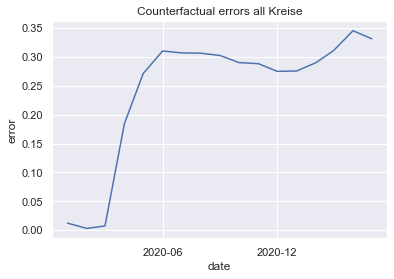

In [240]:
g = sns.lineplot(data=df_all_kreis, x="date", y="error")
g.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
g.set_title('Counterfactual errors all Kreise')
g.legend_.remove()

In [ ]:

df_all_kreis = df_all_kreis.melt(id_vars=['date'], var_name='y_type', value_name='vals')
df_all_kreis

g = sns.lineplot(data=df_all_kreis, x="date", y="vals", style="y_type")
g.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
g.set_title('Counterfactual all Kreise')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.savefig('counter_all_kreis.png')

### Sequential Feature Selector


In [218]:
df_mixed['east_west'] = df_mixed['east_west'].astype(str)
df_mixed['eligible_area'] = df_mixed['eligible_area'].astype(str)
df_mixed['cluster'] = df_mixed['cluster'].astype(str)
df_mixed['urban_rural'] = df_mixed['urban_rural'].astype(str)

X = df_mixed.drop(['kreis','pred','error','ground_truth','Unnamed:_0'], axis=1)
Y = np.log(df_mixed['error'])

X = pd.get_dummies(data=X, drop_first=True)

regr = LinearRegression()
sfs1 = sfs(regr, k_features = 10,forward=True, floating=False, scoring='r2', cv=5)
sfs1.fit(X, Y)

SequentialFeatureSelector(estimator=LinearRegression(), k_features=10,
                          scoring='r2')

In [219]:
summary_table_select = pd.DataFrame.from_dict(sfs1.get_metric_dict()).T
summary_table_select

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(140,)","[-0.00026313836079094877, 0.10085219976487336,...",0.031915,"(wood_area_percentage,)",0.056567,0.044011,0.022006
2,"(117, 140)","[0.04299622984906337, 0.25265083564232915, -0....",0.097728,"(no_of_tourism_points, wood_area_percentage)",0.127489,0.099191,0.049595
3,"(71, 117, 140)","[0.039520638799443564, 0.16581339559129005, 0....",0.113729,"(Proportion_of_in_commuters, no_of_tourism_poi...",0.086685,0.067444,0.033722
4,"(71, 117, 140, 169)","[0.050292740348187204, 0.22899825582212097, 0....",0.127563,"(Proportion_of_in_commuters, no_of_tourism_poi...",0.118929,0.092531,0.046266
5,"(3, 71, 117, 140, 169)","[0.01146311611798323, 0.27826442107050997, 0.1...",0.140274,"(average_distance_bus_stop, Proportion_of_in_c...",0.152839,0.118914,0.059457
6,"(3, 71, 117, 140, 169, 250)","[0.002902392315876856, 0.32276464504488966, 0....",0.162795,"(average_distance_bus_stop, Proportion_of_in_c...",0.179962,0.140016,0.070008
7,"(3, 71, 117, 128, 140, 169, 250)","[0.006022656890293798, 0.3412022424023621, 0.2...",0.168052,"(average_distance_bus_stop, Proportion_of_in_c...",0.181856,0.14149,0.070745
8,"(3, 71, 117, 128, 140, 169, 241, 250)","[0.0012731005053153721, 0.3602747161827373, 0....",0.17334,"(average_distance_bus_stop, Proportion_of_in_c...",0.190956,0.14857,0.074285
9,"(3, 71, 117, 128, 140, 169, 200, 241, 250)","[0.007189292408145254, 0.36027471618273665, 0....",0.177932,"(average_distance_bus_stop, Proportion_of_in_c...",0.183466,0.142743,0.071372
10,"(3, 71, 117, 128, 140, 169, 200, 234, 241, 250)","[0.007048922929503432, 0.37999867848748914, 0....",0.18181,"(average_distance_bus_stop, Proportion_of_in_c...",0.194976,0.151698,0.075849


In [220]:
list(summary_table_select['feature_names'])[:5]

[('wood_area_percentage',),
 ('no_of_tourism_points', 'wood_area_percentage'),
 ('Proportion_of_in_commuters',
  'no_of_tourism_points',
  'wood_area_percentage'),
 ('Proportion_of_in_commuters',
  'no_of_tourism_points',
  'wood_area_percentage',
  'border_proximity'),
 ('average_distance_bus_stop',
  'Proportion_of_in_commuters',
  'no_of_tourism_points',
  'wood_area_percentage',
  'border_proximity')]

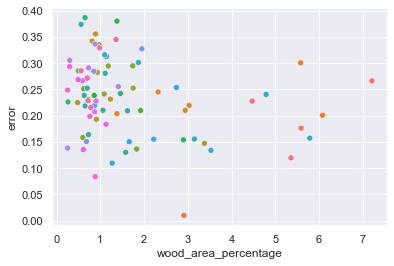

In [223]:
g = sns.scatterplot(data=df_mixed, x="wood_area_percentage", y="error",  hue="ags5")
#g.set_title('MAPE non-crisis VAR model')
g.legend_.remove()

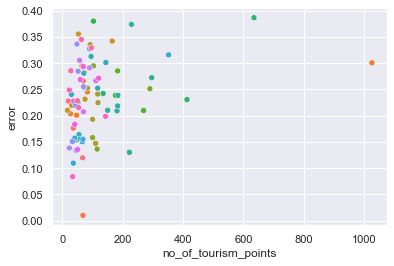

In [224]:
g = sns.scatterplot(data=df_mixed, x="no_of_tourism_points", y="error",  hue="ags5")
#g.set_title('MAPE non-crisis VAR model')
g.legend_.remove()

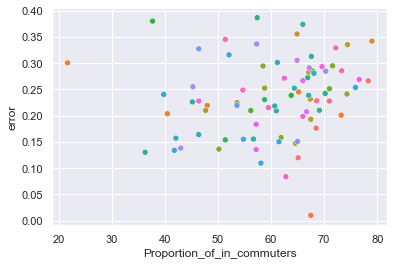

In [225]:
g = sns.scatterplot(data=df_mixed, x="Proportion_of_in_commuters", y="error",  hue="ags5")
#g.set_title('MAPE non-crisis VAR model')
g.legend_.remove()

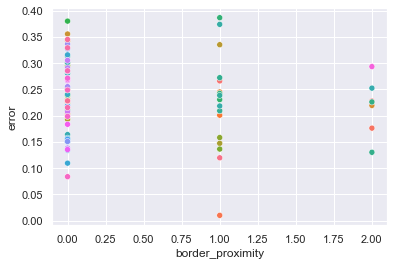

In [226]:
g = sns.scatterplot(data=df_mixed, x="border_proximity", y="error",  hue="ags5")
#g.set_title('MAPE non-crisis VAR model')
g.legend_.remove()

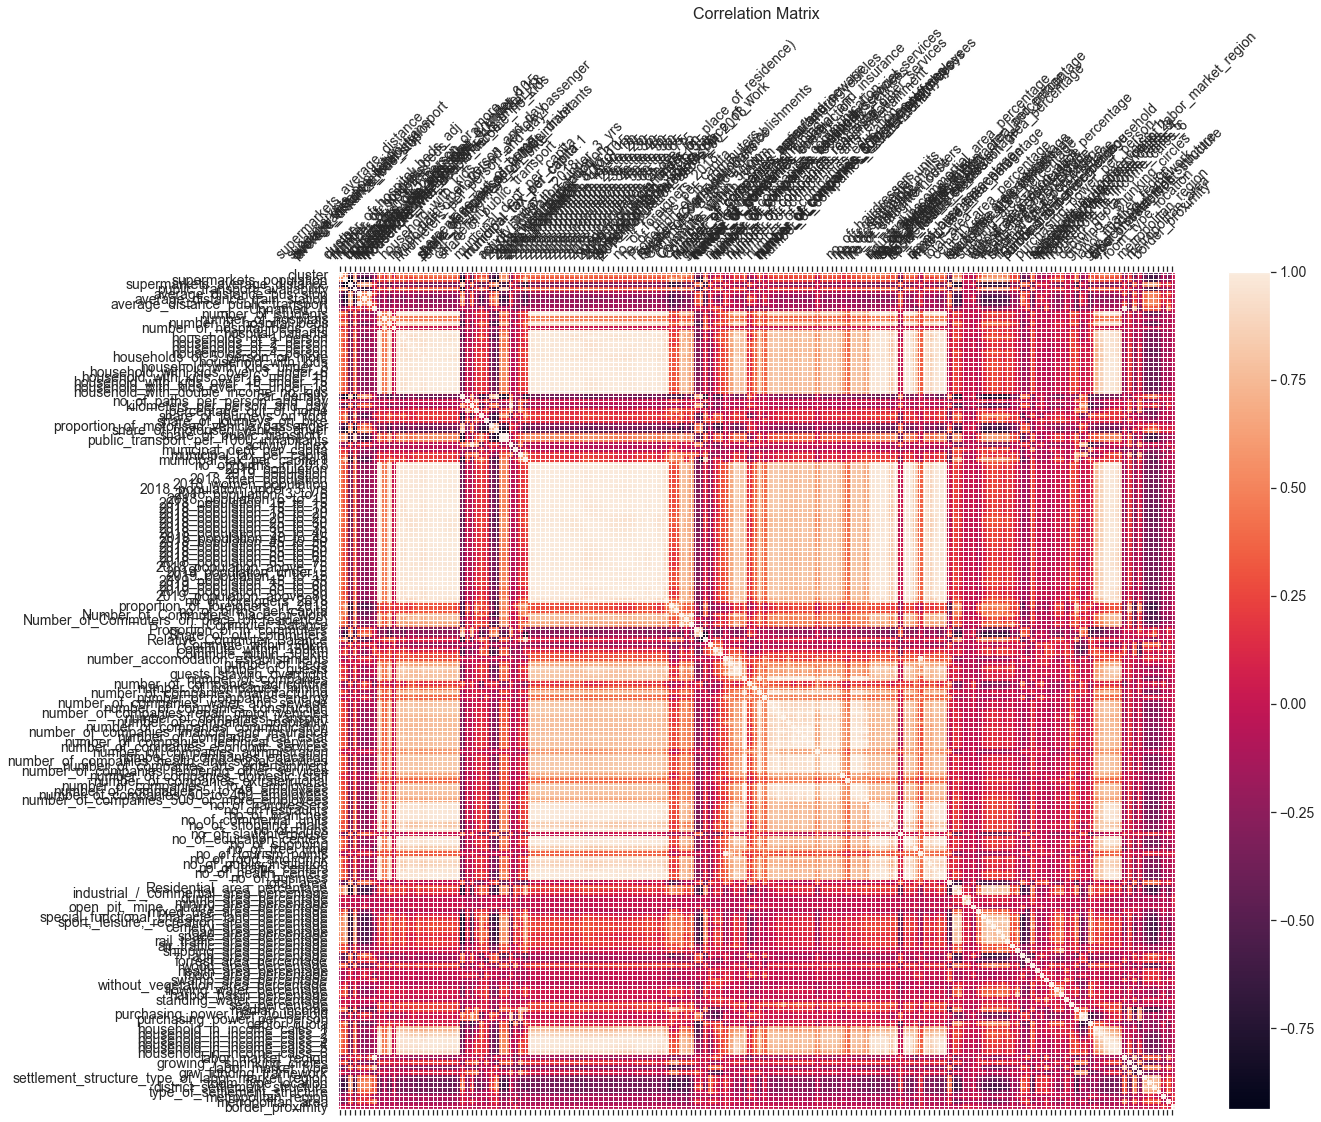

In [250]:
f = plt.figure(figsize=(19, 15))
plt.matshow(df_structural.corr(), fignum=f.number)
plt.xticks(range(df_structural.select_dtypes(['number']).shape[1]), df_structural.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df_structural.select_dtypes(['number']).shape[1]), df_structural.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

In [1]:
 f = Path("/Users/amitsasson/git/thesis_git/R_thesis/simulations/rjob.sh.o4031535")

In [27]: t = f.read_text()

In [28]: times = [float(line[len("Time difference of "):-len(" secs")]) for line in t.split("\n")[:-1]]

In [29]: plt.plot(np.array(times)); plt.show()


NameError: name 'Path' is not defined